<a href="https://colab.research.google.com/github/iupui-soic/pybootcamp/blob/main/MeghaDay2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
df= pd.read_csv ('housing.csv')
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


#Creating test set:

In [2]:
import numpy as np
def split_train_test(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

In [3]:
train_set, test_set = split_train_test(df, 0.2)
len(train_set)

16512

In [4]:
len(test_set)

4128

In [5]:
from zlib import crc32
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32 
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio)) 
    return data.loc[~in_test_set], data.loc[in_test_set]

In [6]:
housing_with_id = df.reset_index() # adds an `index` column 
train_set, test_set = split_train_test_by_id (housing_with_id, 0.2, "index")

In [7]:
housing_with_id["id"] = df["longitude"] * 1000 + df["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [8]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [9]:
df["income_cat"] = pd.cut(df["median_income"],
                                bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

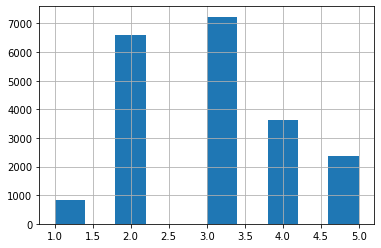

In [10]:
df["income_cat"].hist()

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
  strat_train_set = df.loc[train_index]
  strat_test_set = df.loc[test_index]

In [12]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

#Data Visualization

In [13]:
housing = strat_train_set.copy()

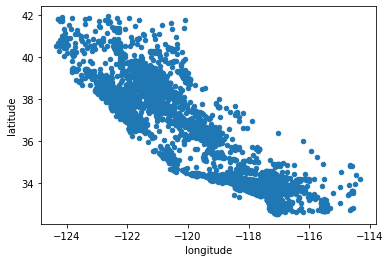

In [14]:
housing.plot(kind="scatter", x="longitude", y="latitude")

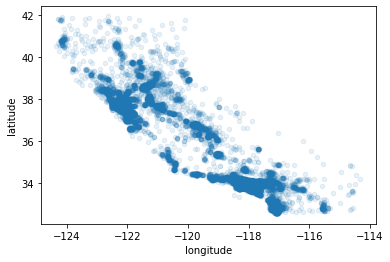

In [15]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

#Correlations:

In [16]:
corr_matrix = housing.corr()

In [17]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe187f4c130>,
      dtype=object)

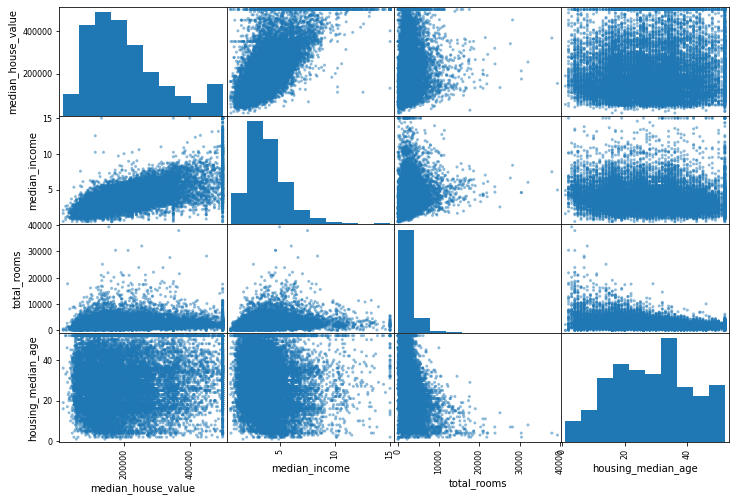

In [18]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
                  "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

In [19]:
df["rooms_per_household"] = df["total_rooms"]/df["households"]
df["bedrooms_per_room"] = df["total_bedrooms"]/df["total_rooms"]
df["population_per_household"]=df["population"]/df["households"]

In [20]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

#Data Processing

In [21]:
df = strat_train_set.drop("median_house_value", axis=1)
df_labels = strat_train_set["median_house_value"].copy()

In [22]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [23]:
housing_num = df.drop("ocean_proximity", axis=1)
housing_cat = df[["ocean_proximity"]]

In [24]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [25]:
X = imputer.transform(housing_num)

In [26]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [27]:
housing_tr.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64

#One hot encoder

In [28]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [29]:
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
    self.add_bedrooms_per_room = add_bedrooms_per_room
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
      rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
      population_per_household = X[:, population_ix] / X[:, households_ix]
      if self.add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
      else:
        return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(df.values)

#Feature Scaling

In [49]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),('attribs_adder', CombinedAttributesAdder()),('std_scaler', StandardScaler()),])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [50]:
from sklearn.metrics.pairwise import rbf_kernel
age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

In [51]:
from sklearn.preprocessing import FunctionTransformer
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

In [52]:
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [53]:
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class ClusterSimilarity(BaseEstimator, TransformerMixin):
  def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
    self.n_clusters = n_clusters
    self.gamma = gamma
    self.random_state = random_state
    
  def fit(self, X, y=None, sample_weight=None):
    self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
    self.kmeans_.fit(X, sample_weight=sample_weight)
    return self # always return self!

  def transform(self, X):
    return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

  def get_feature_names_out(self, names=None):
    return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [55]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]], sample_weight=df_labels)
similarities

array([[5.62462974e-16, 4.87598028e-01, 3.08925612e-01, ...,
        8.47425269e-01, 5.66042074e-08, 1.59544676e-01],
       [3.99661163e-01, 1.40930726e-16, 4.83759068e-22, ...,
        3.47925020e-22, 6.55531541e-05, 5.42668779e-18],
       [2.19628294e-02, 5.54903356e-05, 3.38820768e-08, ...,
        3.96886461e-08, 3.68219529e-01, 5.59389170e-06],
       ...,
       [2.39352264e-20, 3.62134062e-02, 6.34867318e-01, ...,
        9.37591662e-02, 3.52926486e-10, 1.39370410e-01],
       [9.42695335e-20, 4.50178051e-02, 7.32008884e-01, ...,
        8.75923053e-02, 1.01063737e-09, 1.91898354e-01],
       [4.01735580e-25, 2.52869175e-03, 1.24253321e-02, ...,
        1.30706480e-01, 9.10055744e-15, 6.27012814e-04]])

In [60]:
from sklearn.pipeline import make_pipeline
num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [61]:
from sklearn.compose import ColumnTransformer
num_attribs = ["longitude", "latitude", "housing_median_age","total_rooms","total_bedrooms", "population", "households","median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore"))
preprocessing = ColumnTransformer([("num", num_pipeline, num_attribs),("cat", cat_pipeline, cat_attribs),])

In [62]:
from sklearn.compose import make_column_selector, make_column_transformer
preprocessing = make_column_transformer((num_pipeline, make_column_selector(dtype_include=np.number)),(cat_pipeline, make_column_selector(dtype_include=object)),)
     

In [64]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 14)

In [66]:
preprocessing.get_feature_names_out()

AttributeError: ignored

In [67]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared_fr = pd.DataFrame(housing_prepared, columns=preprocessing.get_feature_names_out(), index=housing.index)
housing_prepared_fr.head(2)

AttributeError: ignored

#Training the model

#Linear regression

In [33]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, df_labels)

LinearRegression()

In [34]:

some_data = df.iloc[:5]
some_labels = df_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]


In [35]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(df_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

#Decision tree Regresoor

In [36]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, df_labels)

DecisionTreeRegressor()

In [37]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(df_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

#Evaluation using cross-validation

In [38]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, df_labels,
                          scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [39]:
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())
display_scores(tree_rmse_scores)

Scores: [73499.58028846 71866.16374516 68729.81407825 71803.16640592
 72067.31260603 76842.60567271 71964.69796816 72631.45886511
 68338.57588778 71405.52063573]
Mean: 71914.88961533182
Standard deviation: 2248.1515584945478


In [40]:
lin_scores = cross_val_score(lin_reg, housing_prepared, df_labels,
scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180634


In [41]:
from sklearn.ensemble import RandomForestRegressor

#Hyperparametric tuning

#Grid Search

In [42]:
from sklearn.model_selection import GridSearchCV
param_grid = [
        {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, df_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [43]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [44]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [45]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

64416.33378671999 {'max_features': 2, 'n_estimators': 3}
55465.65507612993 {'max_features': 2, 'n_estimators': 10}
52872.94496975461 {'max_features': 2, 'n_estimators': 30}
59465.16324920331 {'max_features': 4, 'n_estimators': 3}
52259.609786431356 {'max_features': 4, 'n_estimators': 10}
50387.217918781156 {'max_features': 4, 'n_estimators': 30}
59504.78587861059 {'max_features': 6, 'n_estimators': 3}
51740.98256793671 {'max_features': 6, 'n_estimators': 10}
50072.41626943144 {'max_features': 6, 'n_estimators': 30}
59510.22789914129 {'max_features': 8, 'n_estimators': 3}
52236.77541488817 {'max_features': 8, 'n_estimators': 10}
50052.901835092234 {'max_features': 8, 'n_estimators': 30}
62070.007730220306 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54442.70430737979 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60208.824143033424 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52668.9367863672 {'bootstrap': False, 'max_features': 3, 'n_estimators'

#Randomized Search

In [46]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, df_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe180d8bb50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe180d8b490>},
                   random_state=42, scoring='neg_mean_squared_error')

#Test model

In [47]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [48]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
loc=squared_errors.mean(),
scale=stats.sem(squared_errors)))

array([46051.23725164, 49951.42520075])